In [1]:
import pandas as pd
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
import gensim
np.random.seed(7)

import warnings
warnings.filterwarnings("ignore")

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
def delete_redundant_cols(df, cols):
    for col in cols:
        del df[col]
    return df

In [4]:
def preprocess_review_text(review):
    
    review = review.lower()
    
    review = re.sub(r"http\S+|www\S+|https\S+","", review, flags=re.MULTILINE)
    
    review = review.translate(str.maketrans("","", string.punctuation))
    
    review = re.sub(r'\@\w+|\#', "",review)
    
    review_tokens = word_tokenize(review)
    filtered_words = [word for word in review_tokens if word not in stop_words]
    
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(lemma_words)

preprocess_review_text("Hi there, How are you preparing for your exams?")

'hi prepar exam'

In [5]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector


In [6]:
df=pd.read_csv("amazon_fine_food_review.csv", encoding='latin-1',engine="python",error_bad_lines=False)
len(df["Text"])
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [8]:
#Deduplication of entries
final=df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(393933, 10)

In [9]:
review_length = 400    
df_filtered = final[final["Text"].map(len) < review_length] 

In [10]:
len(df_filtered["Text"])

249098

Most used words in the dataset


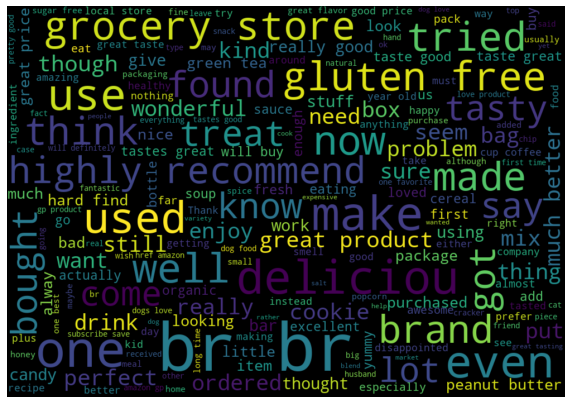

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_reviews = ''.join([sentence for sentence in df_filtered['Text']])
word_cloud = WordCloud(width=1000,height=700,random_state=21,max_font_size=119).generate(all_reviews)
print("Most used words in the dataset")
plt.figure(figsize=(10,10))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
redundant_cols=['Id', 'ProductId', 'UserId', 'ProfileName', 'Time']

df_filtered2=delete_redundant_cols(df_filtered, redundant_cols)

df_filtered2.columns

Index(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Summary',
       'Text'],
      dtype='object')

In [13]:
df_filtered2["Score"].unique()

array([5, 1, 2, 4, 3])

In [14]:
def int_to_string(sentiment):
    if sentiment == 1:
        return "Highly Negative"
    elif sentiment == 2:
        return "Somewhat Negative"
    elif sentiment == 3:
        return "Neutral"
    elif sentiment == 4:
        return "Somewhat Positive"
    else:
        return "Highly Positive"

In [15]:
df_filtered2.Text = df_filtered2["Text"].apply(preprocess_review_text)

In [17]:
df_filtered2

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,1,1,5,Good Quality Dog Food,bought sever vital can dog food product found ...
1,0,0,1,Not as Advertised,product arriv label jumbo salt peanutsth peanu...
3,3,3,2,Cough Medicine,look secret ingredi robitussin believ found go...
4,0,0,5,Great taffy,great taffi great price wide assort yummi taff...
6,0,0,5,Great! Just as good as the expensive brands!,saltwat taffi great flavor soft chewi candi in...
...,...,...,...,...,...
568449,0,0,5,Will not do without,great sesam chickenthi good good restur eaten ...
568450,0,0,2,disappointed,im disappoint flavor chocol note especi weak m...
568451,2,2,5,Perfect for our maltipoo,star small give 1015 one train session tri tra...
568452,1,1,5,Favorite Training and reward treat,best treat train reward dog good groom low cal...


In [18]:
df_filtered2.iloc[:, 4]

0         bought sever vital can dog food product found ...
1         product arriv label jumbo salt peanutsth peanu...
3         look secret ingredi robitussin believ found go...
4         great taffi great price wide assort yummi taff...
6         saltwat taffi great flavor soft chewi candi in...
                                ...                        
568449    great sesam chickenthi good good restur eaten ...
568450    im disappoint flavor chocol note especi weak m...
568451    star small give 1015 one train session tri tra...
568452    best treat train reward dog good groom low cal...
568453    satisfi product advertis use cereal raw vinega...
Name: Text, Length: 249098, dtype: object

In [19]:
df_filtered2.iloc[:, 2]

0         5
1         1
3         2
4         5
6         5
         ..
568449    5
568450    2
568451    5
568452    5
568453    5
Name: Score, Length: 249098, dtype: int64

In [20]:
#data sample is too large, we take part of it
# thresh = 100000    
sample_data_X = df_filtered2.iloc[:, 4]
sample_data_Y = df_filtered2.iloc[:, 2]

tf_vector = get_feature_vector(np.array(sample_data_X).ravel())
X = tf_vector.transform(np.array(sample_data_X).ravel())
y = np.array(sample_data_Y).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
print("X_train shape is:",X_train.shape)
print("X_test shape is:",X_test.shape)

X_train shape is: (174368, 89286)
X_test shape is: (74730, 89286)


### Using a Logistic Regression model to fit the data.

In [21]:
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print("The accuracy score of the Logistic Regression model is:",accuracy_score(y_test, y_predict_lr))

The accuracy score of the Logistic Regression model is: 0.7430483072393952


### Using a MultinomiaLNB model to fit the data.


In [23]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print("The accuracy score of the MultinomialNB model is:",accuracy_score(y_test, y_predict_nb))

The accuracy score of the MultinomialNB model is: 0.6763013515321825


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
count_vect.fit(df_filtered2.iloc[:, 4])
vocabulary = count_vect.get_feature_names()
print('Words in the Vocabulary : ',len(vocabulary))

Words in the Vocabulary :  89286


### Using a Neural Network to fit the data 

In [26]:
sample_data_X = df_filtered2.iloc[:, 4]
sample_data_Y = df_filtered2.iloc[:, 2]

X_train, X_test, y_train, y_test = train_test_split(sample_data_X, sample_data_Y, test_size=0.3, random_state=30)
print(X_train.shape,X_test.shape)

(174368,) (74730,)


In [28]:
from keras.preprocessing.text import Tokenizer
tokeni = Tokenizer()
tokeni.fit_on_texts(X_train)
vocab_size = len(tokeni.word_index) + 1
print("Total words", vocab_size)

Total words 71457


In [29]:
#padding input sequences
max_review_length = 100
X_train = sequence.pad_sequences(tokeni.texts_to_sequences(X_train), maxlen=max_review_length)
X_test = sequence.pad_sequences(tokeni.texts_to_sequences(X_test), maxlen=max_review_length)

In [30]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train.tolist())

LabelEncoder()

In [31]:
y_train = encoder.transform(y_train.tolist())
y_test = encoder.transform(y_test.tolist())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (174368, 1)
y_test (74730, 1)


In [36]:
vocab_size = len(vocabulary)
embedding_vecor_length = 32
epochs = 20

model = Sequential()
model.add(Embedding(vocab_size+1,embedding_vecor_length,input_length= max_review_length))
model.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.4))
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32,activation="relu"))
model.add(Dense(5, activation='softmax'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           2857184   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 100)          53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [37]:
from keras.optimizers import Adam
opt = Adam(lr=0.01)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [38]:
import time
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

start_time = time.time()

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train, y_train,epochs=epochs,batch_size = 1024,shuffle=True,validation_split=0.3,callbacks=callbacks)

end_time = time.time()
time_taken = end_time - start_time

Epoch 1/20
120/120 [==============================] - 93s 774ms/step - loss: 1.0403 - accuracy: 0.6746 - val_loss: 0.8773 - val_accuracy: 0.7079
Epoch 2/20
120/120 [==============================] - 93s 776ms/step - loss: 0.7863 - accuracy: 0.7225 - val_loss: 0.7640 - val_accuracy: 0.7283
Epoch 3/20
120/120 [==============================] - 93s 774ms/step - loss: 0.7125 - accuracy: 0.7372 - val_loss: 0.7679 - val_accuracy: 0.7269
Epoch 4/20
120/120 [==============================] - 93s 773ms/step - loss: 0.6639 - accuracy: 0.7516 - val_loss: 0.7643 - val_accuracy: 0.7303
Epoch 5/20
120/120 [==============================] - 92s 771ms/step - loss: 0.6119 - accuracy: 0.7716 - val_loss: 0.7744 - val_accuracy: 0.7281
Epoch 6/20
120/120 [==============================] - 93s 775ms/step - loss: 0.5680 - accuracy: 0.7892 - val_loss: 0.7901 - val_accuracy: 0.7180
Epoch 7/20
120/120 [==============================] - 92s 770ms/step - loss: 0.5315 - accuracy: 0.8046 - val_loss: 0.8551 - val_ac

In [39]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2336/2336 [==============================] - 121s 52ms/step - loss: 0.8940 - accuracy: 0.7131
Test Loss: 0.8939606547355652
Test Accuracy: 0.7131139039993286


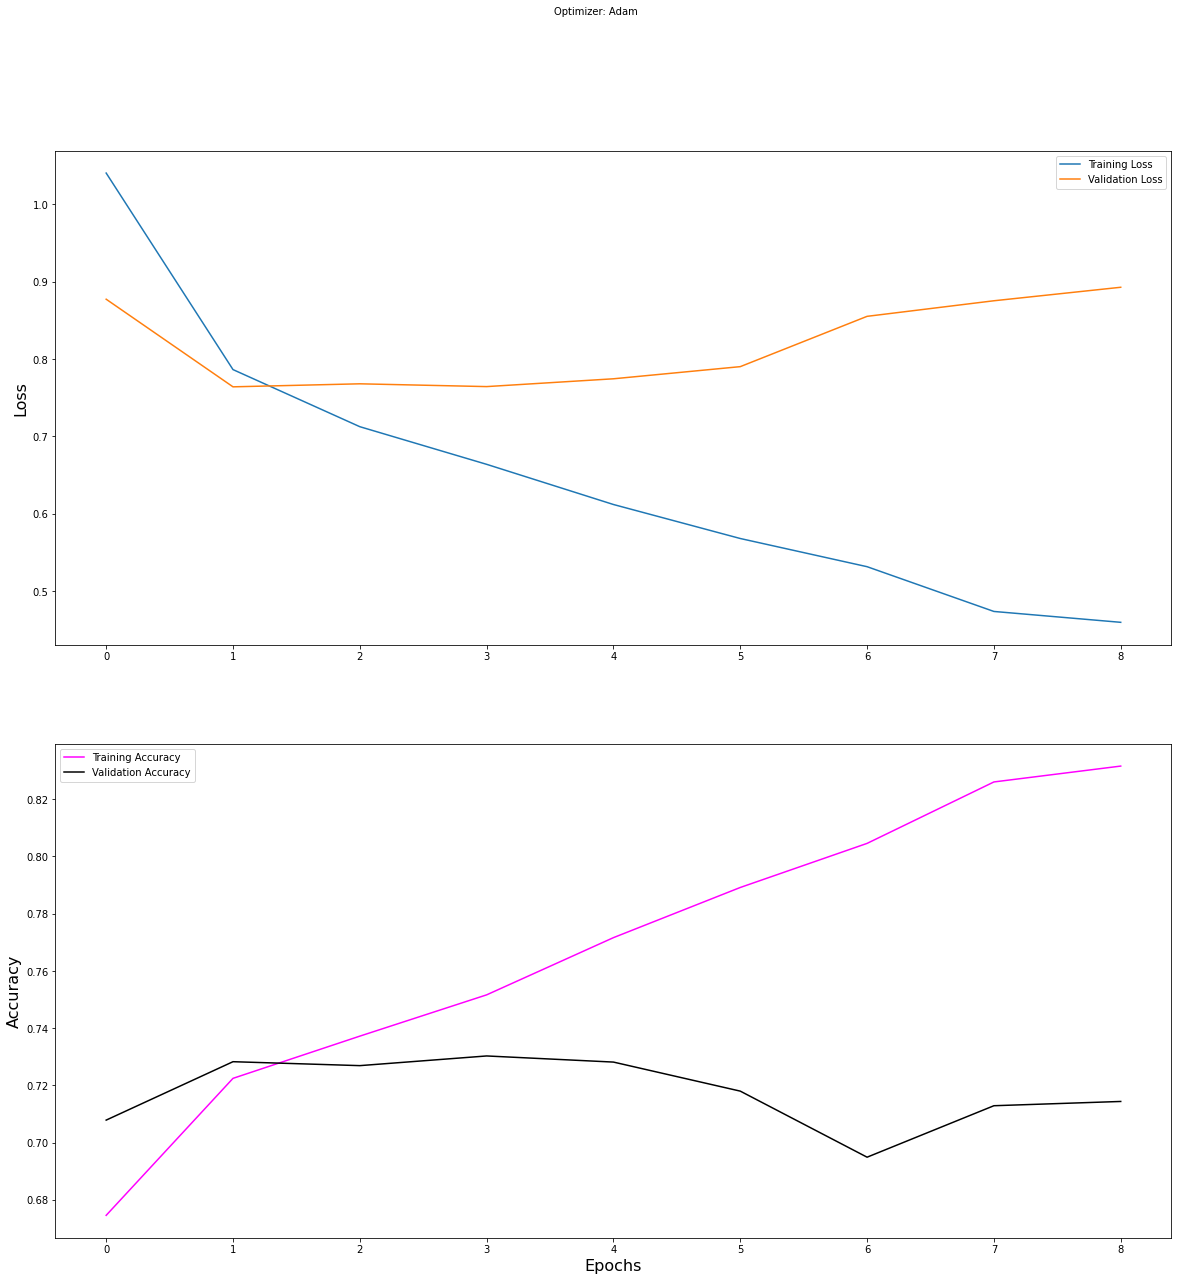

In [41]:
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.suptitle("Optimizer: Adam", fontsize=10)
plt.ylabel("Loss", fontsize=16)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')

#do some printing to visualize
accuracy = np.array(history.history['accuracy'])

val_accuracy = np.array(history.history['val_accuracy'])
avg = 20
a_sum = np.cumsum(accuracy)
v_sum= np.cumsum(val_accuracy)

a_sum[avg:] = a_sum[avg:] - a_sum[:-avg]
a_plot =a_sum[avg-1:]/avg

v_sum[avg:] = v_sum[avg:] - v_sum[:-avg]

v_plot =v_sum[avg-1:]/avg

plt.subplot(2,1,2)
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Epochs",fontsize=16)
# plt.plot(a_plot,label='Training Accuracy',color='blue',marker='o')
plt.plot(history.history['accuracy'],label='Training Accuracy',color='magenta')
# plt.plot(v_plot,label='Validation Accuracy',marker='o',color='red')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy',color='black')
plt.legend(loc='upper left')
plt.show()

In [42]:
def predict(text):
    # Tokenize text
    x_test = sequence.pad_sequences(tokeni.texts_to_sequences([text]), maxlen=max_review_length)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    pred = np.argmax(score)        #get the index of the highest prediction 1,2,3,4,5
    pred_score = score[pred]       #get the highest score from the prediction
#     print(score)
    label = int_to_string(pred)    #get the sentiment based on the prediction

    return {"label": label, "score": pred_score}

In [43]:
test_a = "I loved the product"
test_b = "My order came late, where can I make a complaint?"
test_c =  "The order was broken and was a mess, I will be asking for a refund"
test_d = "The product was okay, not really great"
test_e = "I am so happy I bought this product, I am going to buy more soon"

tests = [test_a,test_b,test_c,test_d,test_e]
test_label = ['Highly Positive','somewhat Negative','Highly Negative','Neutral','Highly Positive']
ind = [1,2,3,4,5]

acc = []
for i,test,label in zip(ind,tests,test_label):
    result = predict(test)
    print("Test "+str(i)+" result:",result,"  ","Actual label is:",str(label))



Test 1 result: {'label': 'Somewhat Positive', 'score': 0.39142117}    Actual label is: Highly Positive
Test 2 result: {'label': 'Neutral', 'score': 0.34431556}    Actual label is: somewhat Negative
Test 3 result: {'label': 'Highly Positive', 'score': 0.37479568}    Actual label is: Highly Negative
Test 4 result: {'label': 'Neutral', 'score': 0.42109236}    Actual label is: Neutral
Test 5 result: {'label': 'Somewhat Positive', 'score': 0.9893645}    Actual label is: Highly Positive
